### Data generation
(Optional; in case you do not have real gene sequence data)

In [1]:
from metal import Metal 
from utils.plot_tree import print_tree, plot_tree
from utils.treetools import save_trees, compute_split_frequencies, add_labels_to_tree, get_bipartitions
from data_generation import TreeSimulator, SequenceSimulator
import random
import os 
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

In [2]:
num_gene_trees = 100
ntax= 15
num_sites_per_gene = 100
mutation_rate = 0.1
species_tree_diameter = 1.0

In [3]:
dir_name = "data"

if dir_name not in os.listdir("."):  
    os.mkdir(dir_name)

In [4]:
rng = random.Random(0)

tree_sim = TreeSimulator(ntax=ntax, tree_diameter=species_tree_diameter, rng=rng)

# Generate species tree
tree_sim.generate_species_tree()
tree_sim.get_species_tree().write(path=f"{dir_name}/species_tree.nex", schema="nexus")

# Generate gene trees
gene_trees = tree_sim.generate_multiple_gene_trees(num_gene_trees)
gene_trees.write(path=f"{dir_name}/gene_trees.nex", schema="nexus")

Species tree generated.
Gene trees generated.


In [5]:
print_tree(tree_sim.get_species_tree(), show_lengths=False)

└── *
    ├── *
    │   ├── j
    │   └── *
    │       ├── *
    │       │   ├── d
    │       │   └── *
    │       │       ├── n
    │       │       └── *
    │       │           ├── c
    │       │           └── *
    │       │               ├── m
    │       │               └── a
    │       └── *
    │           ├── *
    │           │   ├── *
    │           │   │   ├── e
    │           │   │   └── h
    │           │   └── g
    │           └── f
    └── *
        ├── b
        └── *
            ├── k
            └── *
                ├── o
                └── *
                    ├── l
                    └── i


In [6]:
#Generate a fasta file of the concatenated sequences of gene trees

seq_sim = SequenceSimulator(seq_length=num_sites_per_gene, mutation_rate=mutation_rate, seed=0)

fasta_filepath = f"{dir_name}/concatenated_seq_alignment.fasta"
seq_sim.write_concatenated(gene_trees, fasta_filepath)

Generating & concatenating sequences: 100%|█████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.85it/s]


In [7]:
est = Metal(fasta_filepath, seed = 0)
est.estimate_tree()
print_tree(est.metal_tree, show_support=False, show_lengths=False)

└── *
    ├── *
    │   ├── b
    │   └── *
    │       ├── k
    │       └── *
    │           ├── o
    │           └── *
    │               ├── l
    │               └── i
    └── *
        ├── *
        │   ├── f
        │   └── *
        │       ├── h
        │       └── *
        │           ├── e
        │           └── g
        └── *
            ├── j
            └── *
                ├── a
                └── *
                    ├── m
                    └── *
                        ├── c
                        └── *
                            ├── d
                            └── n


In [8]:
boot_trees = est.bootstrap_hamming(n_bootstraps = 100)
gauss_trees = est.gaussian_sampling(n_bootstraps = 1000, mutation_rate=mutation_rate, sites_per_gene=num_sites_per_gene)

Gaussian sample tree reconstruction: 100%|███████████████████████████████████████████████| 1000/1000 [00:01<00:00, 682.27it/s]


In [9]:
boot_freqs = compute_split_frequencies(est.metal_tree, boot_trees)
gauss_freqs = compute_split_frequencies(est.metal_tree, gauss_trees)
metal_boot_support = add_labels_to_tree(est.metal_tree, boot_freqs, inplace = False)
metal_gauss_support = add_labels_to_tree(est.metal_tree, gauss_freqs, inplace = False)

In [10]:
print(" Bootstrap ".center(30,"#"))
print_tree(metal_boot_support,show_lengths=False)
print(" Gaussian ".center(30,"#"))
print_tree(metal_gauss_support,show_lengths=False)

######### Bootstrap ##########
└── *
    ├── [1.000]
    │   ├── b
    │   └── [0.980]
    │       ├── k
    │       └── [0.740]
    │           ├── o
    │           └── [0.980]
    │               ├── l
    │               └── i
    └── [1.000]
        ├── [0.960]
        │   ├── f
        │   └── [1.000]
        │       ├── h
        │       └── [1.000]
        │           ├── e
        │           └── g
        └── [0.910]
            ├── j
            └── [1.000]
                ├── a
                └── [0.720]
                    ├── m
                    └── [0.960]
                        ├── c
                        └── [0.440]
                            ├── d
                            └── n
########## Gaussian ##########
└── *
    ├── [1.000]
    │   ├── b
    │   └── [0.693]
    │       ├── k
    │       └── [0.580]
    │           ├── o
    │           └── [0.712]
    │               ├── l
    │               └── i
    └── [0.982]
        ├── [0.788]
        │   ├── f


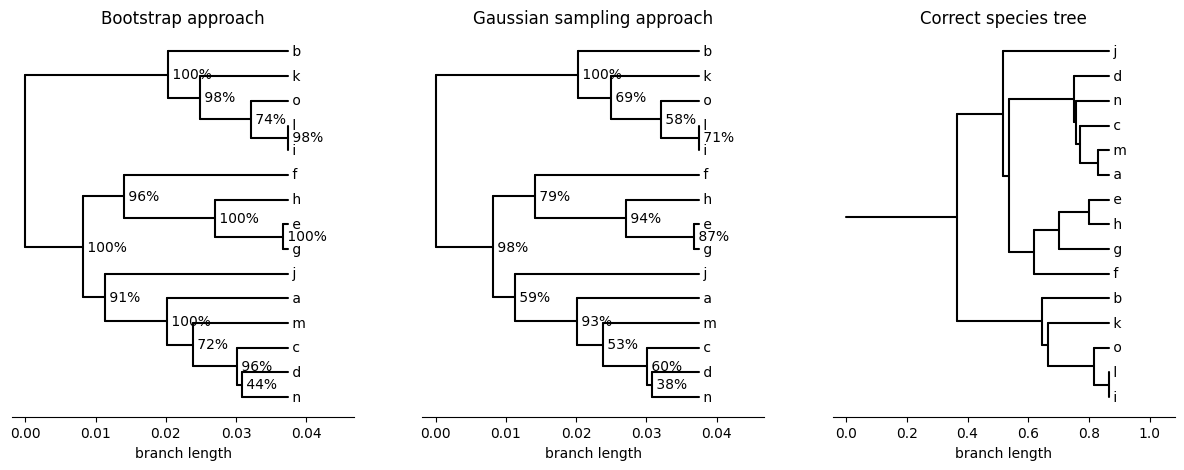

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
plot_tree(metal_boot_support, ax = ax1)
plot_tree(metal_gauss_support, ax = ax2)
plot_tree(tree_sim.species_tree, ax = ax3)

ax1.set_title("Bootstrap approach")
ax2.set_title("Gaussian sampling approach")
ax3.set_title("Correct species tree")

plt.show()